# 桥梁裂缝检测

下载数据集：

```sh
kaggle datasets download -d xinzone/surface-crack
```

回到根目录：

In [1]:
cd ../..

E:\kaggle\crack-book


获取数据集的根目录：

In [2]:
from apps.dataset import kaggle_root
# 获取数据根目录
root = kaggle_root() + '/datasets/xinzone/surface-crack/surface-crack.zip'

读取图片：

In [3]:
from zipfile import ZipFile
from PIL import Image
import numpy as np


def name2bunch(namelist):
    '''将 namelist 转换为 bunch'''
    name_bunch = {}
    for name in namelist:
        ns = name.split('/')
        name_type = ns[0]
        if name_type == 'predict':
            name_bunch.setdefault(name_type, []).append(name)
        else:
            label = ns[1]
            name_bunch.setdefault(name_type, []).append((name, label))
    return name_bunch


class ZipImage:
    def __init__(self, Z):
        '''
        Z: 图片的 ZipFile 对象
        '''
        self.Z = Z
        self.name_bunch = name2bunch(self.Z.namelist())

    def array(self, name):
        '''获取给定的 name 的图片像素信息'''
        with self.Z.open(name) as fp:
            with Image.open(fp) as im:
                img = np.array(im)
        return img

    def split(self, data_type):
        '''
        data_type: 'test', 'train', 'valid', 'predict'
        '''
        for ns in self.name_bunch[data_type]: 
            if ns == 'predict':
                img = self.array(ns)
                yield img
            else:
                name, label = ns
                img = self.array(name)
                yield img, label

In [4]:
Z = ZipFile(root)

I = ZipImage(Z)

train = I.split('train')
test = I.split('test')
valid = I.split('valid')
predict = I.split('predict')

Negative


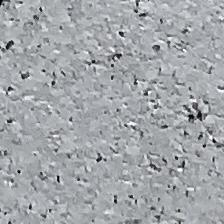

In [5]:
for img, label in train:
    print(label)
    break

Image.fromarray(img)

## 图片灰度化

选择一张阳性的图片：

In [6]:
img = I.array('train/Positive/IMG_0487_9_13.jpg')
im = Image.fromarray(img)

获取 `R`, `G`, `B`：

In [7]:
def RGB(im):
    R, G, B = im.split()
    R = np.array(R)
    G = np.array(G)
    B = np.array(B)
    return R, G, B

R, G, B = RGB(im)

图像灰度化的基本原理是：在 YUV 的颜色空间中，`Y` 分量代表了点的亮度，该值反映的是亮度等级信息。`Y` 分量的计算方法如下所示：

$$
Y = 0.3 R + 0.59 G + 0.11 B
$$

In [8]:
def gray(im):
    R, G, B = RGB(im)
    Y = 0.3*R + 0.59*G + 0.11*B 
    Y = Y.astype('uint8') # 将浮点数转换为 uint8
    return Y

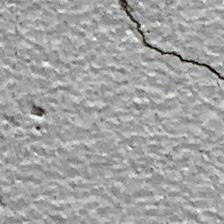

In [9]:
im

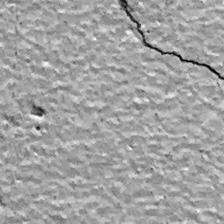

In [10]:
Y = gray(im)

Image.fromarray(Y) # 灰度化的结果

## 波谷阈值分割

经过细心的观察训练样本 patch，我们发现，含有裂缝的正样本 patch 的灰度分布，有一个很明显的特点：正样本 patch 的灰度分布存在一个明显的全局波谷，小于此波谷灰度值的部分对应裂缝像素，大于此波谷灰度值的部分对应非裂缝像素。

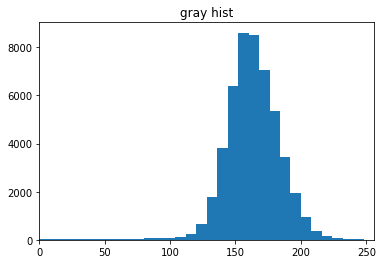

In [12]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.hist(Y.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)
ax.set_title('gray hist');

## Canny Edge

In [21]:
from sklearn.preprocessing import LabelBinarizer
from skimage.filters import median
from skimage.morphology import disk
from scipy import ndimage
from skimage.filters import laplace
import cv2


# def sobel_filters(img):
#     Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
#     Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

#     Ix = ndimage.filters.convolve(img, Kx)
#     Iy = ndimage.filters.convolve(img, Ky)

#     G = np.hypot(Ix, Iy)
#     G = G / G.max() * 255
#     theta = np.arctan2(Iy, Ix)
#     return G, theta


def canny_edge(gray):
    # noise removal
    blur_img = median(gray, disk(3))
    blur_img = np.array(blur_img, dtype=np.uint8)
    #s = np.array(s,dtype=np.uint8)
    # Image smoothing: bilateral filter
    bilateral = cv2.bilateralFilter(blur_img, 5, 75, 75)
    # Canny edge detection
    edges = cv2.Canny(bilateral, 100, 220)
    return edges

In [22]:
edges = canny_edge(Y)

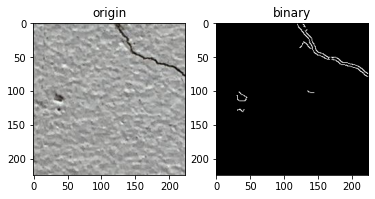

In [25]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img, cmap='gray')
ax[0].set_title('origin')
ax[1].imshow(edges, cmap='gray')
ax[1].set_title('binary')
plt.show()